# 导入需要用到的库

In [5]:
import os
import time
import random
import itertools
from pprint import pprint

from tqdm import tqdm
from string import Template
from collections import namedtuple
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image

import cupy as cp
import cupy
import numpy as np
import xml.etree.ElementTree as ET

import torch
import torch as t
from torch import nn
from torch.autograd import Function
from torch.nn import functional as F

from torchvision.models import vgg16
from skimage import transform as sktsf
from torchvision import transforms as tvtsf
from torchnet.meter import ConfusionMeter, AverageValueMeter

from nms import non_maximum_suppression
from roi_cupy import kernel_backward, kernel_forward
import array_tool as at

In [2]:
%matplotlib notebook

# 配置文件

In [3]:
class Config:
    # data
    voc_data_dir = 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/'
    min_size = 600  # image resize
    max_size = 1000 # image resize
    
    # sigma for l1_smooth_loss
    rpn_sigma = 3.
    roi_sigma = 1.

    weight_decay = 0.0005
    lr_decay = 0.1  # 1e-3 -> 1e-4
    lr = 1e-3

    # preset
    data = 'voc'
    pretrained_model = 'vgg16'

    # training
    epoch = 14

    # debug
    debug_file = '/tmp/debugf'

    test_num = 100
    # model
    load_path = r'D:\BaiduNetdiskDownload\simple-faster-rcnn\chainer_best_model_converted_to_pytorch_0.7053.pth'

    def _parse(self, kwargs):
        state_dict = self._state_dict()
        for k, v in kwargs.items():
            if k not in state_dict:
                raise ValueError('UnKnown Option: "--%s"' % k)
            setattr(self, k, v)

        print('======user config========')
        pprint(self._state_dict())
        print('==========end============')

    def _state_dict(self):
        return {k: getattr(self, k) for k, _ in Config.__dict__.items() \
                if not k.startswith('_')}

opt = Config()

# 输入数据

## 数据输入时用到的工具

In [8]:
# 读取图片,值为[0-255]
# color模式：RGB彩色图片,通道数最前
def read_image(path, dtype=np.float32, color=True):
    """Read an image from a file.

    This function reads an image from given file. The image is CHW format and
    the range of its value is :math:`[0, 255]`. If :obj:`color = True`, the
    order of the channels is RGB.

    Args:
        path (str): A path of image file.
        dtype: The type of array. The default value is :obj:`~numpy.float32`.
        color (bool): This option determines the number of channels.
            If :obj:`True`, the number of channels is three. In this case,
            the order of the channels is RGB. This is the default behaviour.
            If :obj:`False`, this function returns a grayscale image.

    Returns:
        ~numpy.ndarray: An image.
    """

    f = Image.open(path)
    try:
        if color:
            img = f.convert('RGB')
        else:
            img = f.convert('P')
        img = np.asarray(img, dtype=dtype)
    finally:
        if hasattr(f, 'close'):
            f.close()

    if img.ndim == 2:
        # reshape (H, W) -> (1, H, W)
        return img[np.newaxis]
    else:
        # transpose (H, W, C) -> (C, H, W)
        return img.transpose((2, 0, 1))

In [9]:
# 实现对pytorch模型输入图像的标准化：
# 把[0,1]的RGB正则化为均值为0,标准差为1的正态分布的RGB。
def img_normalize(img):
    normalize = tvtsf.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img = normalize(t.from_numpy(img))
    return img.numpy()

In [10]:
# 函数preprocess实现对图像的预处理：
# 由read_image函数读入的图像为CHW的[0，255]格式，这里首先除以255，
# 再按照论文长边不超1000，短边不超600缩放。
# 然后对图像进行正则化。
def preprocess(img, min_size=600, max_size=1000):
    """Preprocess an image for feature extraction.
    Args:
        img (~numpy.ndarray): An image. This is in CHW and RGB format.
            The range of its value is :math:`[0, 255]`.
    Returns:
        ~numpy.ndarray: A preprocessed image.

    """
    C, H, W = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale = min(scale1, scale2)
    img = img / 255.
    img = sktsf.resize(img, (C, H * scale, W * scale), mode='reflect',anti_aliasing=False)
    
    return img_normalize(img)

In [11]:
# 根据图像尺寸变化，改变bbox的尺寸
# bbox: (r,4) 表示一张图片有r个真实物体，4依次代表y1,x1,y2,x2的坐标
def resize_bbox(bbox, in_size, out_size):
    """Resize bounding boxes according to image resize.
    Args:
        bbox (~numpy.ndarray): An array whose shape is :math:`(R, 4)`.
            :math:`R` is the number of bounding boxes.
        in_size (tuple): A tuple of length 2. The height and the width
            of the image before resized.
        out_size (tuple): A tuple of length 2. The height and the width
            of the image after resized.

    Returns:
        ~numpy.ndarray:
        Bounding boxes rescaled according to the given image shapes.

    """
    bbox = bbox.copy()
    y_scale = float(out_size[0]) / in_size[0]
    x_scale = float(out_size[1]) / in_size[1]
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]
    return bbox

In [12]:
# Transform类整合了上面了几个方法
class Transform(object):

    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = preprocess(img, self.min_size, self.max_size)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        return img, bbox, label, scale

In [13]:
# 去正则化,用于输出原始图像。
def inverse_normalize(img):
    # approximate un-normalize for visualize
    return (img * 0.225 + 0.45).clip(min=0, max=1) * 255

## 建立输入数据库 

In [14]:
# 标签对应的名字。
VOC_BBOX_LABEL_NAMES = (
    'aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
    'chair','cow','diningtable','dog','horse','motorbike','person',
    'pottedplant','sheep','sofa','train','tvmonitor')

In [15]:
# 读取VOC数据
# labels: (R,) R代表了一张图里真实物体的数量，值为0,1,2,...,代表前面那个元组里第几个元素。
class VOCBboxDataset:
    """Bounding box dataset for PASCAL `VOC`_.

    The index corresponds to each image.

    When queried by an index, if :obj:`return_difficult == False`,
    this dataset returns a corresponding
    :obj:`img, bbox, label`, a tuple of an image, bounding boxes and labels.
    This is the default behaviour.
    If :obj:`return_difficult == True`, this dataset returns corresponding
    :obj:`img, bbox, label, difficult`. :obj:`difficult` is a boolean array
    that indicates whether bounding boxes are labeled as difficult or not.

    The labels are packed into a one dimensional tensor of shape :math:`(R,)`.
    :math:`R` is the number of bounding boxes in the image.
    The class name of the label :math:`l` is :math:`l` th element of
    :obj:`VOC_BBOX_LABEL_NAMES`.

    The array :obj:`difficult` is a one dimensional boolean array of shape
    :math:`(R,)`. :math:`R` is the number of bounding boxes in the image.
    If :obj:`use_difficult` is :obj:`False`, this array is
    a boolean array with all :obj:`False`.

    Args:
        data_dir (string): Path to the root of the training data. 
        split ({'train', 'val', 'trainval', 'test'}): Select a split of the dataset.
        year ({'2007', '2012'}): Use a dataset prepared for a challenge
        use_difficult (bool): If :obj:`True`, use images that are labeled as
            difficult in the original annotation.
        return_difficult (bool): If :obj:`True`, this dataset returns
            a boolean array that indicates whether bounding boxes are labeled as difficult
            or not. The default value is :obj:`False`.

    """

    def __init__(self, data_dir, split='trainval',
                 use_difficult=False, return_difficult=False,
                 ):
        
        # 这个file保存了训练集和验证集的编号(trainval.txt)。
        id_list_file = os.path.join(
            data_dir, 'ImageSets/Main/{0}.txt'.format(split))

        self.ids = [id_.strip() for id_ in open(id_list_file)]
        self.data_dir = data_dir
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult
        self.label_names = VOC_BBOX_LABEL_NAMES

    def __len__(self):
        return len(self.ids)

    def get_example(self, i):
        """Returns the i-th example.

        Returns a color image and bounding boxes. The image is in CHW format.
        The returned image is RGB.

        Returns:
            tuple of an image and bounding boxes

        """
        id_ = self.ids[i]
        anno = ET.parse(os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
        bbox = list()
        label = list()
        difficult = list()
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue

            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(VOC_BBOX_LABEL_NAMES.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool).astype(np.uint8)  # PyTorch don't support np.bool

        # Load a image
        img_file = os.path.join(self.data_dir, 'JPEGImages', id_ + '.jpg')
        img = read_image(img_file, color=True)

        # if self.return_difficult:
        #     return img, bbox, label, difficult
        return img, bbox, label, difficult

    __getitem__ = get_example

In [16]:
# 读取数据集
class Dataset:
    def __init__(self, opt):
        self.opt = opt
        self.db = VOCBboxDataset(opt.voc_data_dir)
        self.tsf = Transform(opt.min_size, opt.max_size)

    def __getitem__(self, idx):
        ori_img, bbox, label, difficult = self.db.get_example(idx)
        img, bbox, label, scale = self.tsf((ori_img, bbox, label))
        return img.copy(), bbox.copy(), label.copy(), scale

    def __len__(self):
        return len(self.db)

In [14]:
dataset = Dataset(opt)

In [15]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [106]:
# 这个函数用来看看一个样本的图形、bbox、对应的类别，和scale大小。
# 注意：只显示dataloader返回Batch的第一张图片。
def vis_train(img, bbox, label, scale):
    # 因为Batchsize = 1, 所以可以这么些哦~
    
    img = inverse_normalize(img[0].numpy())
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))

    for i in range(len(bbox[0])):
        y1 = bbox[0][i][0]
        x1 = bbox[0][i][1]
        y2 = bbox[0][i][2]
        x2 = bbox[0][i][3]
        height = y2 - y1
        width = x2 - x1
        ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=2))
        ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[label[0][i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    
    ax.text(10,10,'Scale='+str(scale.numpy()[0]),style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    return ax

In [107]:
img, bbox, label, scale = next(iter(dataloader))

<IPython.core.display.Javascript object>


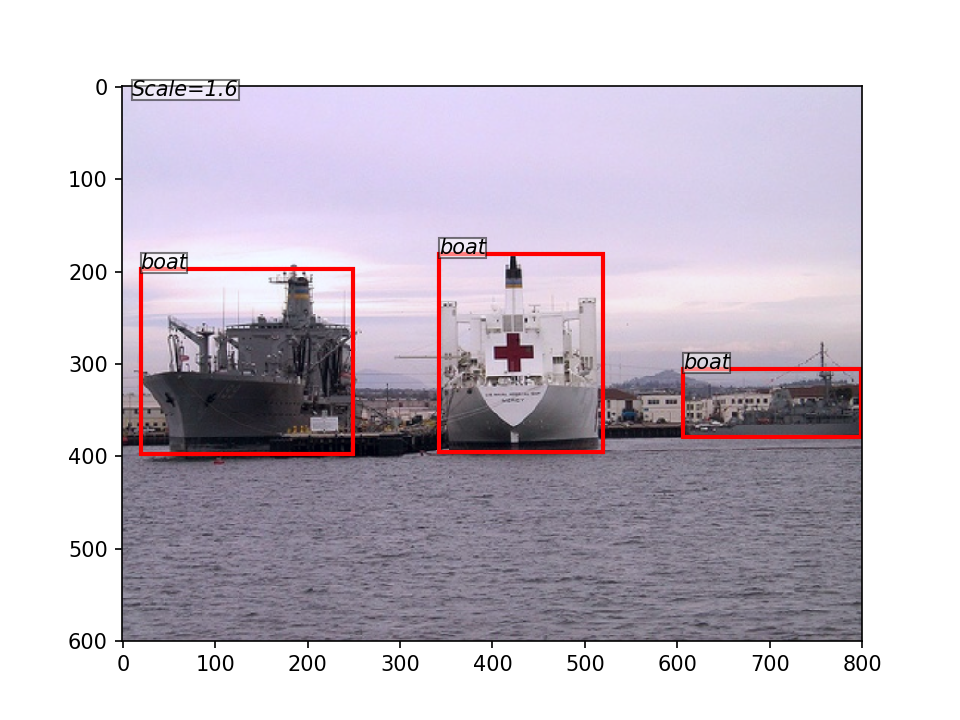

In [108]:
vis_train(img, bbox, label, scale)

# backbone网络

In [45]:
# 肢解VGG16网络，因为我们只用了其中的一部分。
# 返回前面的卷积层组，提取信息
# 和最后的分类全卷积层。cmd还不知道用来干嘛的。
def decom_vgg16():
    # the 30th layer of features is relu of conv5_3
    model = vgg16(pretrained=False)

    features = list(model.features)[:30]
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6] #out=1000的全连接层
    del classifier[5] #Dropout层2
    del classifier[2] #Dropout层1
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False

    return nn.Sequential(*features), classifier

# Regional Proposal Network

## Anchors生成

In [21]:
# 这个函数的作用就是产生(0,0)坐标开始的基础的9个anchor框
# 分析一下函数的参数base_size=16就是基础的anchor的宽和高其实是16的大小
# 再根据不同的放缩比和宽高比进行进一步的调整
# ratios就是指的宽高的放缩比分别是0.5:1,1:1,1:2
# 最后一个参数是anchor_scales也就是在base_size的基础上再增加的量，
# 本代码中对应着三种面积的大小(16*8)^2 (16*16)^2 (16*32)^2  
# 也就是128,256,512的平方大小，三种面积乘以三种放缩比就刚刚好是9种anchor

def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    """Generate anchor base windows by enumerating aspect ratio and scales.

    Generate anchors that are scaled and modified to the given aspect ratios.
    Area of a scaled anchor is preserved when modifying to the given aspect
    ratio.

    `R = len(ratios) * len(anchor_scales)` anchors are generated by this function.
    The `i * len(anchor_scales) + j` th anchor corresponds to an anchor generated by `ratios[i]` and `anchor_scales[j]`.

    For example, if the scale is :`8` and the ratio is :`0.25`,
    the width and the height of the base window will be stretched by :`8`.
    For modifying the anchor to the given aspect ratio, the height is halved and the width is doubled.

    Args:
        base_size (number): The width and the height of the reference window.
        ratios (list of floats): This is ratios of width to height of the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            `anchor_scales` and the original area of the reference window.

    Returns:
        ~numpy.ndarray:
        An array of shape :math:`(R, 4)`.
        Each element is a set of coordinates of a bounding box.

    """
    py = base_size / 2.
    px = base_size / 2.

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base

In [22]:
anchors = generate_anchor_base()
print(anchors.shape)
print(anchors[0])

(9, 4)
[-37.254833 -82.50967   53.254833  98.50967 ]


In [77]:
np.power(2,7.5)

181.01933598375618

<IPython.core.display.Javascript object>


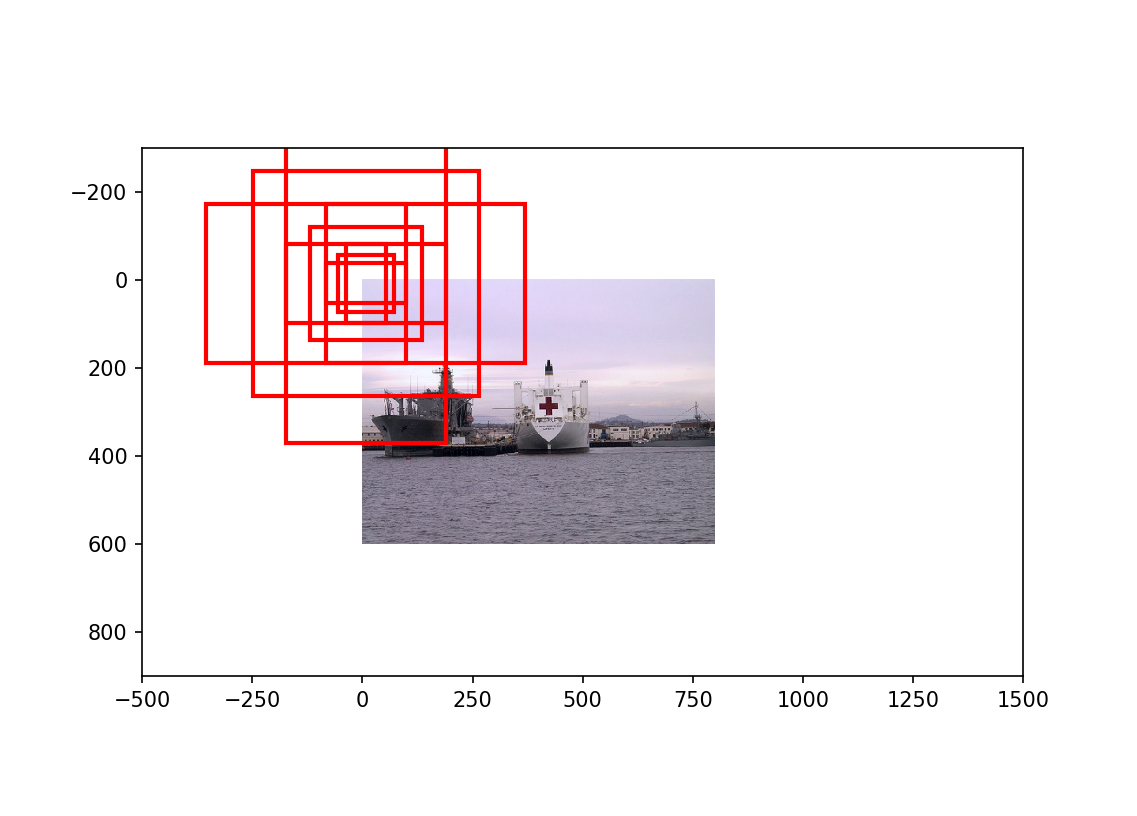

In [130]:
# ratio = 宽/高
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(inverse_normalize(img[0].numpy()).transpose((1, 2, 0)).astype(np.uint8))
ax.set_xlim([-500,1500])
ax.set_ylim([900,-300])
for i in range(9):
    x1 = anchors[i][0]
    y1 = anchors[i][1]
    x2 = anchors[i][2]
    y2 = anchors[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=2))

In [23]:
# 根据上面函数在0,0生成的anchor_base,再原图的所有点上生成anchors
def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):

    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor

In [140]:
# 用到了Python的广播机制。
# shift的第一行加上所有anchor_base,就得到了9个anchor_base在原图0,0的坐标
# shift的第二行加上所有anchor_base,就得到了9个anchor_base在原图0,16的坐标
# 看下面的all_anchor[0]和all_anchor[9]
(shift.shape) == 480000,4
(shift_x.shape) == 600,800
shift

(480000, 4)
(600, 800)


array([[    0,     0,     0,     0],
       [    0,    16,     0,    16],
       [    0,    32,     0,    32],
       ...,
       [ 9584, 12752,  9584, 12752],
       [ 9584, 12768,  9584, 12768],
       [ 9584, 12784,  9584, 12784]])

In [145]:
all_anchor[0]

array([-37.254833, -82.50967 ,  53.254833,  98.50967 ], dtype=float32)

In [146]:
all_anchor[9]

array([-37.254833, -66.50967 ,  53.254833, 114.50967 ], dtype=float32)

In [142]:
# 600,800 = img.shape[2:]
# 16 = feat_stride
all_anchor = _enumerate_shifted_anchor(np.array(anchors),16, 600, 800)
all_anchor.shape == 4320000
# 4320000 = 600*800*9

<IPython.core.display.Javascript object>


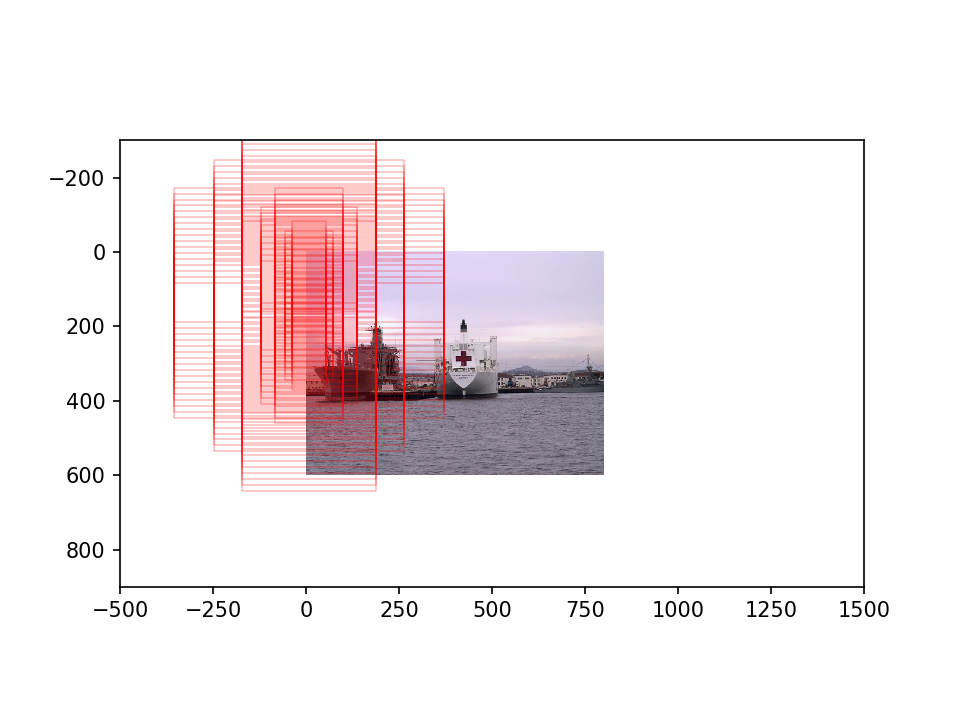

In [159]:
# ratio = 宽/高
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(inverse_normalize(img[0].numpy()).transpose((1, 2, 0)).astype(np.uint8))
ax.set_xlim([-500,1500])
ax.set_ylim([900,-300])
# 等了三分钟画不出4320000个。。。少画一点吧。

for i in range(159):
    x1 = all_anchor[i][0]
    y1 = all_anchor[i][1]
    x2 = all_anchor[i][2]
    y2 = all_anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=.2))

In [ ]:
注意： 这里其实不能这么画的。
后面的训练过程你们会发现，其实是在feature map上的每个点生成9个anchors

比如原图800*600，下采样倍数16，那么就会生成
(800/16)*(600/16)*9 = 50*37*9 = 16650个anchor (网上教程都会说约20000个，但根据输入图像的不同，还是有差别的。)


## Anchor Target Creator
生成Anchor的真实偏移量

In [24]:
# 计算哪些Anchor完全落在图片内部。
def _get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) & #y1
        (anchor[:, 1] >= 0) & #x1
        (anchor[:, 2] <= H) & #y2
        (anchor[:, 3] <= W)   #x2
    )[0]
    return index_inside

In [173]:
anchor = np.matrix([[1,2,3,4],[1,3,3,4],[1,4,5,7]])
H = 5
W = 4

# 加个[0]返回行索引，cmd也不知道第二组索引是干嘛的。。。
np.where(
        (anchor[:, 0] >= 0) & #y1
        (anchor[:, 1] >= 0) & #x1
        (anchor[:, 2] <= H) & #y2
        (anchor[:, 3] <= W)   #x2
    )

(array([0, 1], dtype=int64), array([0, 0], dtype=int64))

In [25]:
# 计算两个（a1,4）,（a2,4）形状bbox的所有iou
# 返回一个（a1,a2）形状的矩阵，
# 每i行，第j列代表第一个bbox列表的第i个box与第二个bbox列表第j个box的iou
def bbox_iou(bbox_a, bbox_b):
    """Calculate the Intersection of Unions (IoUs) between bounding boxes.
    Please note that both `bbox_a` and `bbox_b` need to be same type.
    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
    Returns:
        array:
        An array whose shape is `(N, K)`. 
        An element at index :`(n, k)` contains IoUs between `n` th bounding box 
        in `bbox_a` and `k` th bounding box in `bbox_b`.
    """
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError
    
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

In [212]:
bbox_a = np.array([[0,0,4,4],[1,1,2,2]])
bbox_b = np.array([[2,2,4,4],[1,1,4,4],[0,0,2,2]])
print(bbox_a[:, None, :2])
print("----")
print(bbox_b[:, :2])

[[[0 0]]

 [[1 1]]]
----
[[2 2]
 [1 1]
 [0 0]]


In [218]:
# 总之这个函数很Nb，聪明貂也没看懂！
bbox_iou(bbox_a, bbox_b)

array([[0.25      , 0.5625    , 0.25      ],
       [0.        , 0.11111111, 0.25      ]])

In [214]:
tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])
area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)

In [215]:
print(br - tl)
print("----")
print(np.prod(br - tl, axis=2))  # np.prod() 连乘

[[[2 2]
  [3 3]
  [2 2]]

 [[0 0]
  [1 1]
  [1 1]]]
----
[[4 9 4]
 [0 1 1]]


In [216]:
print((tl < br).all(axis=2))
print(area_i)

[[ True  True  True]
 [False  True  True]]
[[4 9 4]
 [0 1 1]]


In [26]:
# 计算以x,y,w,h形式的两个bbox之间的offset.
# src_bbox: anchor 所有的anchor
# dst_bbox: bbox[argmax_ious] 每个anchor对应iou最大的bbox
def bbox2loc(src_bbox, dst_bbox):
    """Encodes the source and the destination bounding boxes to "loc".

    Given bounding boxes, this function computes offsets and scales
    to match the source bounding boxes to the target bounding boxes.
    
    Args:
        src_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
            These coordinates are :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        dst_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. These coordinates are
            :math:`g_{ymin}, g_{xmin}, g_{ymax}, g_{xmax}`.

    Returns:
        array:
        Bounding box offsets and scales from `src_bbox` to `dst_bbox`. \
        This has shape :math:`(R, 4)`.
        The second axis contains four values :math:`t_y, t_x, t_h, t_w`.

    """
    # 真实的x,y,w,h
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width
    # anchor的x,y,w,h
    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width
    
    #考虑到除法的分母是不能为0的，而且式子中log内也不能为负数，不然会直接跳出显示错误。
    #eps开始的三行将可能出现的负数和零，使用eps来替换，这样就不会出现错误了。
    #finfo函数是根据height.dtype类型来获得信息，获得符合这个类型的float型，eps是取非负的最小值。
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc

In [27]:
# 把前面除掉的不完全在图片以内的anchors拿回来。
def _unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of size count)

    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
        
    return ret

In [28]:
# 目的：利用每张图中bbox的真实标签来为所有任务分配ground truth！
# 输入：最初生成的20000个anchor坐标、此一张图中所有的bbox的真实坐标
# 输出：size为（20000，1）的正负label（其中只有128个为1，128个为0，其余都为-1
#       size为（20000，4）的回归目标（所有anchor的坐标都有）

# 将20000多个候选的anchor选出256个anchor进行二分类和所有的anchor进行回归位置 。为上面的预测值提供相应的真实值。选择方式如下：
# 对于每一个ground truth bounding box (gt_bbox)，选择和它重叠度（IoU）最高的一个anchor作为正样本。
# 对于剩下的anchor，从中选择和任意一个gt_bbox重叠度超过0.7的anchor，作为正样本，正样本的数目不超过128个。
# 随机选择和gt_bbox重叠度小于0.3的anchor作为负样本。负样本和正样本的总数为256。
# 对于每个anchor, gt_label 要么为1（前景），要么为0（背景），所以这样实现二分类。
# 在计算回归损失的时候，只计算正样本（前景）的损失，不计算负样本的位置损失。

class AnchorTargetCreator(object):
    """Assign the ground truth bounding boxes to anchors.

    Assigns the ground truth bounding boxes to anchors for training Region Proposal Networks.
    
    Offsets and scales to match anchors to the ground truth are
    calculated using the encoding scheme of bbox2loc.

    Args:
        n_sample (int): The number of regions to produce.
        pos_iou_thresh (float): Anchors with IoU above this threshold will be assigned as positive.
        neg_iou_thresh (float): Anchors with IoU below this threshold will be assigned as negative.
        pos_ratio (float): Ratio of positive regions in the sampled regions.

    """

    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):
        """Assign ground truth supervision to sampled subset of anchors.

        * `S` is the number of anchors.
        * `R` is the number of bounding boxes.

        Args:
            bbox (array): Coordinates of bounding boxes. Its shape is `(R, 4)`.
            anchor (array): Coordinates of anchors. Its shape is math:`(S, 4)`.
            img_size (tuple of ints): A tuple `H, W`, which is a tuple of height and width of an image.

        Returns:
            (array, array):

            * **loc**: Offsets and scales to match the anchors to the ground truth bounding boxes. 
            Its shape is :math:`(S, 4)`.
            * **label**: Labels of anchors with values `(1=positive, 0=negative, -1=ignore)`. 
            Its shape is :math:`(S,)`.

        """

        img_H, img_W = img_size

        n_anchor = len(anchor)
        inside_index = _get_inside_index(anchor, img_H, img_W)
        anchor = anchor[inside_index]
        # argmax_ious [S,] 每个Anchor对应iou最大的bbox是第几个
        # label 每个Anchor是正样本(1)、负样本(0)还是忽略(-1)。
        argmax_ious, label = self._create_label(inside_index, anchor, bbox)

        # compute bounding box regression targets
        # 因为anchor还是x1y1x2y2的形式，转换成delta t形式
        # [R,4]
        loc = bbox2loc(anchor, bbox[argmax_ious])

        # map up to original set of anchors
        # 把不全在图里面的anchor恢复回来，label为-1，loc为0
        label = _unmap(label, n_anchor, inside_index, fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):
        # label: 1 is positive, 0 is negative, -1 is dont care
        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)
        # argmax_ious [S,] 每个Anchor对应iou最大的bbox是第几个
        # max_ious 每个anchor对应iou最大bbox的iou值
        # gt_argmax_ious 对于每一个(gt_bbox)，和它IoU最高的一个anchor的位置
        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox, inside_index)

        # assign negative labels first so that positive labels can clobber them
        # 如果每个anchor对应bbox的最大iou值都小于0.3,那么这就是负样本。
        label[max_ious < self.neg_iou_thresh] = 0

        # positive label: for each gt, anchor with highest iou
        # 每个bbox对应最大iou的那些anchor为正样本
        label[gt_argmax_ious] = 1

        # positive label: above threshold IOU
        # 每个anchor对应bbox的最大iou值都大于0.7,那么这也是正样本
        label[max_ious >= self.pos_iou_thresh] = 1

        # subsample positive labels if we have too many
        # 正样本不能太多
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # subsample negative labels if we have too many
        # 负样本也不能太多，正+负=256。正的不够128，负的来凑。
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label
    
    # 这个类内函数用来计算ious
    def _calc_ious(self, anchor, bbox, inside_index):
        # ious between the anchors and the gt boxes
        # [S,R] S个anchor,R个bbox
        ious = bbox_iou(anchor, bbox)
        # [S,] 每个Anchor对应iou最大的bbox是第几个
        argmax_ious = ious.argmax(axis=1)
        # 返回每个anchor对应iou最大bbox的iou值。
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        
        # [R,] 每个bbox对应iou最大的Anchor是第几个。
        gt_argmax_ious = ious.argmax(axis=0)
        # 返回每个bbox对应iou最大anchor的iou值
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        # 对于每一个(gt_bbox)，选择和它IoU最高的一个anchor作为正样本。
        # 正样本anchor的位置
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]
        
        return argmax_ious, max_ious, gt_argmax_ious

## Proposal Creator

RPN利用 AnchorTargetCreator自身训练的同时，还会提供RoIs（region of interests）给Fast RCNN（RoIHead）作为训练样本。RPN生成RoIs的过程(ProposalCreator)如下：

对于每张图片，利用它的feature map， 计算 (H/16)× (W/16)×9（大概20000）个anchor属于前景的概率，以及对应的位置参数。选取概率较大的12000个anchor利用回归的位置参数，修正这12000个anchor的位置，得到RoIs。

利用非极大值（(Non-maximum suppression, NMS）抑制，选出概率最大的2000个RoIs

注意：在inference的时候，为了提高处理速度，12000和2000分别变为6000和300.

注意：这部分的操作不需要进行反向传播，因此可以利用numpy/tensor实现。

RPN的输出：RoIs（形如2000×4或者300×4的tensor）

In [68]:
#把x,y,w,h转化回x1,y1,x2,y2的形式
def loc2bbox(src_bbox, loc):
    """Decode bounding boxes from bounding box offsets and scales.

    Given bounding box offsets and scales computed by
    :meth:`bbox2loc`, this function decodes the representation to
    coordinates in 2D image coordinates.

    The output is same type as the type of the inputs.

    Args:
        src_bbox (array): A coordinates of bounding boxes.
            Its shape is :math:`(R, 4)`. These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        loc (array): An array with offsets and scales.
            The shapes of :obj:`src_bbox` and :obj:`loc` should be same.
            This contains values :math:`t_y, t_x, t_h, t_w`.

    Returns:
        array:
        Decoded bounding box coordinates. Its shape is :math:`(R, 4)`. 
        The second axis contains four values 
        :`\\hat{g}_{ymin}, \\hat{g}_{xmin}, \\hat{g}_{ymax}, \\hat{g}_{xmax}`.

    """

    if src_bbox.shape[0] == 0:
        return xp.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox

In [30]:
# 目的：为Fast-RCNN也即检测网络提供2000个训练样本
# 输入：RPN网络中1*1卷积输出的loc和score，以及20000个anchor坐标，原图尺寸，scale（即对于这张训练图像较其原始大小的scale）
# 输出：2000个训练样本rois（只是2000*4的坐标，无ground truth！）
class ProposalCreator:
    """Proposal regions are generated by calling this object.

    `__call__` of this object outputs object detection proposals by applying
    estimated bounding box offsets to a set of anchors.

    This class takes parameters to control number of bounding boxes to pass to NMS and keep after NMS.
    If the paramters are negative, it uses all the bounding boxes supplied or keep all the bounding boxes returned by NMS.


    Args:
        nms_thresh (float): Threshold value used when calling NMS.
        n_train_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in train mode.
        n_train_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in train mode.
        n_test_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in test mode.
        n_test_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in test mode.
        force_cpu_nms (bool): If this is :obj:`True`,
            always use NMS in CPU mode. If :obj:`False`,
            the NMS mode is selected based on the type of inputs.
        min_size (int): A paramter to determine the threshold on
            discarding bounding boxes based on their sizes.

    """

    def __init__(self,parent_model,nms_thresh=0.7,
                 n_train_pre_nms=12000,n_train_post_nms=2000,
                 n_test_pre_nms=6000,n_test_post_nms=300,
                 min_size=16):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score, anchor, img_size, scale=1.):
        """input should be ndarray Propose RoIs.

        Inputs :`loc, score, anchor` refer to the same anchor when indexed
        by the same index.

        On notations, :`R` is the total number of anchors. This is equal
        to product of the height and the width of an image and the number of
        anchor bases per pixel.

        Args:
            loc (array): Predicted offsets and scaling to anchors. Its shape is :math:`(R, 4)`.
            score (array): Predicted foreground probability for anchors. Its shape is :math:`(R,)`.
            anchor (array): Coordinates of anchors. Its shape is `(R, 4)`.
            img_size (tuple of ints): A tuple `height, width`,  which contains image size after scaling.
            scale (float): The scaling factor used to scale an image after reading it from a file.

        Returns:
            array:
            An array of coordinates of proposal boxes.
            Its shape is `(S, 4)`. :math:`S` is less than `self.n_test_post_nms` in test time 
            and less than `self.n_train_post_nms` in train time. 
            `S` depends on the size of the predicted bounding boxes and the number of bounding boxes discarded by NMS.

        """
        # NOTE: when test, remember
        # faster_rcnn.eval()
        # to set self.traing = False
        if self.parent_model.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # Convert anchors into proposal via bbox transformations.
        roi = loc2bbox(anchor, loc)

        # Clip predicted boxes to image.
        # y小于图片高度
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        # x小于图片宽度
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

        # Remove predicted boxes with either height or width < threshold.
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN (e.g. 6000).
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]

        # Apply nms (e.g. threshold = 0.7).
        # Take after_nms_topN (e.g. 300).

        # unNOTE: somthing is wrong here!
        # TODO: remove cuda.to_gpu
        keep = non_maximum_suppression(cp.ascontiguousarray(cp.asarray(roi)), thresh=self.nms_thresh)
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi

## Proposal Target Creator
ProposalTargetCreator是RPN网络与ROIHead网络的过渡操作，前面讲过，RPN会产生大约2000个RoIs，这2000个RoIs不是都拿去训练，而是利用ProposalTargetCreator 选择128个RoIs用以训练。选择的规则如下：

RoIs和gt_bboxes 的IoU大于0.5的，选择一些（比如32个）
选择 RoIs和gt_bboxes的IoU小于等于0（或者0.1）的选择一些（比如 128-32=96个）作为负样本
为了便于训练，对选择出的128个RoIs，还对他们的gt_roi_loc 进行标准化处理（减去均值除以标准差）

对于分类问题,直接利用交叉熵损失. 而对于位置的回归损失,一样采用Smooth_L1Loss, 只不过只对正样本计算损失.而且是只对正样本中的这个类别4个参数计算损失。举例来说:

一个RoI在经过FC 84后会输出一个84维的loc 向量. 如果这个RoI是负样本,则这84维向量不参与计算 L1_Loss
如果这个RoI是正样本,属于label K,那么它的第 K×4, K×4+1 ，K×4+2， K×4+3 这4个数参与计算损失，其余的不参与计算损失。

In [31]:
# 目的：为2000个rois赋予ground truth！（严格讲挑出128个赋予ground truth！）
# 输入：2000个rois、一个batch（一张图）中所有的bbox ground truth（R，4）、对应bbox所包含的label（R，1）（VOC2007来说20类0-19）
# 输出：128个sample roi（128，4）、128个gt_roi_loc（128，4）、128个gt_roi_label（128，1）

class ProposalTargetCreator(object):
    """Assign ground truth bounding boxes to given RoIs.

    The :meth:`__call__` of this class generates training targets
    for each object proposal.

    Args:
        n_sample (int): The number of sampled regions.
        pos_ratio (float): Fraction of regions that is labeled as a foreground.
        pos_iou_thresh (float): IoU threshold for a RoI to be considered as a foreground.
        neg_iou_thresh_hi (float): RoI is considered to be the background if IoU is in
            [:obj:`neg_iou_thresh_lo`, :obj:`neg_iou_thresh_hi`).
        neg_iou_thresh_lo (float): See above.

    """

    def __init__(self,n_sample=128,
                 pos_ratio=0.25, pos_iou_thresh=0.5,
                 neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_hi = neg_iou_thresh_hi
        self.neg_iou_thresh_lo = neg_iou_thresh_lo  # NOTE:default 0.1 in py-faster-rcnn

    def __call__(self, roi, bbox, label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        """Assigns ground truth to sampled proposals.

        This function samples total of `self.n_sample` RoIs from the combination of 
        `roi` and `bbox`. The RoIs are assigned with the ground truth class labels 
        as well as bounding box offsets and scales to match the ground truth bounding
        boxes. As many as `pos_ratio * self.n_sample` RoIs are sampled as foregrounds.

        Here are notations.

        * `S` is the total number of sampled RoIs, which equals `self.n_sample`.
        * `L` is number of object classes possibly including the background.

        Args:
            roi (array): Region of Interests (RoIs) from which we sample.
                Its shape is :math:`(R, 4)`
            bbox (array): The coordinates of ground truth bounding boxes.
                Its shape is :math:`(R', 4)`.
            label (array): Ground truth bounding box labels. Its shape
                is :math:`(R',)`. Its range is :math:`[0, L - 1]`, where
                `L` is the number of foreground classes.
            loc_normalize_mean (tuple of four floats): Mean values to normalize
                coordinates of bouding boxes.
            loc_normalize_std (tupler of four floats): Standard deviation of
                the coordinates of bounding boxes.

        Returns:
            (array, array, array)
            * **sample_roi**: Regions of interests that are sampled. 
                Its shape is :math:`(S, 4)`.
            * **gt_roi_loc**: Offsets and scales to match the sampled 
                    RoIs to the ground truth bounding boxes. Its shape is :math:`(S, 4)`.
            * **gt_roi_label**: Labels assigned to sampled RoIs. Its shape is 
                `(S,)`. Its range is :math:`[0, L]`. The label with value 0 is the background.

        """
        n_bbox, _ = bbox.shape

        roi = np.concatenate((roi, bbox), axis=0)

        pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        iou = bbox_iou(roi, bbox)
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)
        # Offset range of classes from [0, n_fg_class - 1] to [1, n_fg_class].
        # The label with value 0 is the background.
        gt_roi_label = label[gt_assignment] + 1

        # Select foreground RoIs as those with >= pos_iou_thresh IoU.
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

        # Select background RoIs as those within
        # [neg_iou_thresh_lo, neg_iou_thresh_hi).
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) & (max_iou >= self.neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

        # The indices that we're selecting (both positive and negative).
        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels --> 0
        sample_roi = roi[keep_index]

        # Compute offsets and scales to match sampled RoIs to the GTs.
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32)) / np.array(loc_normalize_std, np.float32))

        return sample_roi, gt_roi_loc, gt_roi_label

## Region Proposal Network

RPN网络的输入为图像特征。RPN网络是全卷积网络。RPN网络要完成的任务是训练自己、提供rois。

训练自己：二分类、bounding box 回归（由AnchorTargetCreator实现）

提供rois：为Fast-RCNN提供训练需要的rois（由ProposalCreator实现）

RPN网络流程我们之前介绍过一部分，这里完整的实现整个网络。

首先初始化网络的结构：特征（N，512，h，w）输入进来（原图像的大小：16*h，16*w），首先是加pad的512个3*3大小卷积核，输出仍为（N，512，h，w）。然后左右两边各有一个1*1卷积。左路为18个1*1卷积，输出为（N，18，h，w），即所有anchor的0-1类别概率（h*w约为2400，h*w*9约为20000）。右路为36个1*1卷积，输出为（N，36，h，w），即所有anchor的回归位置参数。

前向传播：输入特征即feature map，调用函数_enumerate_shifted_anchor生成全部20000个anchor。然后特征经过卷积，在经过两路卷积分别输出rpn_locs, rpn_scores。然后rpn_locs, rpn_scores作为ProposalCreator的输入产生2000个rois，同时还有 roi_indices，这个 roi_indices在此代码中是多余的，因为我们实现的是batch_siae=1的网络，一个batch只会输入一张图象。如果多张图象的话就需要存储索引以找到对应图像的roi。

In [32]:
# 用来为权重初始化
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

In [33]:
class RegionProposalNetwork(nn.Module):
    """Region Proposal Network introduced in Faster R-CNN.

    Args:
        in_channels (int): The channel size of input.
        mid_channels (int): The channel size of the intermediate tensor.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.
        feat_stride (int): Stride size after extracting features from an
            image.

        proposal_creator_params (dict): Key valued paramters for
            :class:`model.utils.creator_tools.ProposalCreator`.

    """

    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            proposal_creator_params=dict(),
    ):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        """Forward Region Proposal Network.

        Here are notations.

        * :math:`N` is batch size.
        * :math:`C` channel size of the input.
        * :math:`H` and :math:`W` are height and witdh of the input feature.
        * :math:`A` is number of anchors assigned to each pixel.

        Args:
            x (~torch.autograd.Variable): The Features extracted from images.
                Its shape is :math:`(N, C, H, W)`.
            img_size (tuple of ints): A tuple :obj:`height, width`,
                which contains image size after scaling.
            scale (float): The amount of scaling done to the input images after
                reading them from files.

        Returns:
            (~torch.autograd.Variable, ~torch.autograd.Variable, array, array, array):

            This is a tuple of five following values.

            * **rpn_locs**: Predicted bounding box offsets and scales for anchors. Its shape is :math:`(N, H W A, 4)`.
            * **rpn_scores**:  Predicted foreground scores for anchors. Its shape is :math:`(N, H W A, 2)`.
            * **rois**: A bounding box array containing coordinates of proposal boxes.  
            This is a concatenation of bounding box arrays from multiple images in the batch. 
            Its shape is :math:`(R', 4)`. Given :math:`R_i` predicted bounding boxes from the :math:`i` th image
            * **roi_indices**: An array containing indices of images to which RoIs correspond to. Its shape is :math:`(R',)`.
            * **anchor**: Coordinates of enumerated shifted anchors. Its shape is :math:`(H W A, 4)`.

        """
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)

        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i].cpu().data.numpy(), rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size, scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        return rpn_locs, rpn_scores, rois, roi_indices, anchor

# Region of Interests Network

In [34]:
#这些代码是用来反向传播的应该。

Stream = namedtuple('Stream', ['ptr'])
CUDA_NUM_THREADS = 1024

@cupy.util.memoize(for_each_device=True)
def load_kernel(kernel_name, code, **kwargs):
    cp.cuda.runtime.free(0)
    code = Template(code).substitute(**kwargs)
    kernel_code = cupy.cuda.compile_with_cache(code)
    return kernel_code.get_function(kernel_name)

def GET_BLOCKS(N, K=CUDA_NUM_THREADS):
    return (N + K - 1) // K

## ROI Pooling 

In [35]:
# 有些没看懂
class RoI(Function):
    def __init__(self, outh, outw, spatial_scale):
        self.forward_fn = load_kernel('roi_forward', kernel_forward)
        self.backward_fn = load_kernel('roi_backward', kernel_backward)
        self.outh, self.outw, self.spatial_scale = outh, outw, spatial_scale

    def forward(self, x, rois):
        # NOTE: MAKE SURE input is contiguous too
        x = x.contiguous()
        rois = rois.contiguous()
        self.in_size = B, C, H, W = x.size()
        self.N = N = rois.size(0)
        output = t.zeros(N, C, self.outh, self.outw).cuda()
        self.argmax_data = t.zeros(N, C, self.outh, self.outw).int().cuda()
        self.rois = rois
        args = [x.data_ptr(), rois.data_ptr(),
                output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.spatial_scale, C, H, W,
                self.outh, self.outw,
                output.numel()]
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        self.forward_fn(args=args,
                        block=(CUDA_NUM_THREADS, 1, 1),
                        grid=(GET_BLOCKS(output.numel()), 1, 1),
                        stream=stream)
        return output

    def backward(self, grad_output):
        ##NOTE: IMPORTANT CONTIGUOUS
        # TODO: input
        grad_output = grad_output.contiguous()
        B, C, H, W = self.in_size
        grad_input = t.zeros(self.in_size).cuda()
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        args = [grad_output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.rois.data_ptr(),
                grad_input.data_ptr(),
                self.N, self.spatial_scale, C, H, W, self.outh, self.outw,
                grad_input.numel()]
        self.backward_fn(args=args,
                         block=(CUDA_NUM_THREADS, 1, 1),
                         grid=(GET_BLOCKS(grad_input.numel()), 1, 1),
                         stream=stream
                         )
        return grad_input, None




In [36]:
class RoIPooling2D(t.nn.Module):

    def __init__(self, outh, outw, spatial_scale):
        super(RoIPooling2D, self).__init__()
        self.RoI = RoI(outh, outw, spatial_scale)

    def forward(self, x, rois):
        return self.RoI(x, rois)

In [37]:
class VGG16RoIHead(nn.Module):
    """Faster R-CNN Head for VGG-16 based implementation.
    This class is used as a head for Faster R-CNN.
    This outputs class-wise localizations and classification based on feature
    maps in the given RoIs.
    
    Args:
        n_class (int): The number of classes possibly including the background.
        roi_size (int): Height and width of the feature maps after RoI-pooling.
        spatial_scale (float): Scale of the roi is resized.
        classifier (nn.Module): Two layer Linear ported from vgg16

    """

    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        # n_class includes the background
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = RoIPooling2D(self.roi_size, self.roi_size, self.spatial_scale)

    def forward(self, x, rois, roi_indices):
        """Forward the chain.

        We assume that there are :`N` batches.

        Args:
            x (Variable): 4D image variable.
            rois (Tensor): A bounding box array containing coordinates of
                proposal boxes.  This is a concatenation of bounding box
                arrays from multiple images in the batch.
                Its shape is :`(R', 4)`. Given :math:`R_i` proposed
                RoIs from the `i` th image,
            roi_indices (Tensor): An array containing indices of images to
                which bounding boxes correspond to. Its shape is :math:`(R',)`.
        """
        # in case roi_indices is  ndarray
        roi_indices = at.totensor(roi_indices).float()
        rois = at.totensor(rois).float()
        indices_and_rois = t.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous()

        pool = self.roi(x, indices_and_rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        return roi_cls_locs, roi_scores

# Faster RCNN

## 损失函数

In [38]:
def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = t.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [39]:
def nograd(f):
    def new_f(*args,**kwargs):
        with t.no_grad():
            return f(*args,**kwargs)
    return new_f

## 把前面的部件全部组合起来

In [40]:
class FasterRCNN(nn.Module):
    """Base class for Faster R-CNN.

        This is a base class for Faster R-CNN links supporting object detection
        API [#]_. 

        The following three stages constitute Faster R-CNN.

        1. **Feature extraction**: Images are taken and their feature maps are calculated.

        2. **Region Proposal Networks**: Given the feature maps calculated in the previous stage, produce set of RoIs around objects.

        3. **Localization and Classification Heads**: Using feature maps that belong to the proposed RoIs, 
                                                      classify the categories of the objects in the RoIs and improve localizations.

        Each stage is carried out by one of the callable
        :class:`torch.nn.Module` objects :`feature`, `rpn` and `head`.

        There are two functions :`predict` and :`__call__` to conduct object detection.

        :`predict` takes images and returns bounding boxes that are converted to image coordinates. 
                This will be useful for a scenario when Faster R-CNN is treated as a black box function, for instance.
        :`__call__` is provided for a scnerario when intermediate outputs are needed, for instance, for training and debugging.

        Args:
            extractor (nn.Module): A module that takes a BCHW image array and returns feature maps.
            rpn (nn.Module)
            head (nn.Module): A module that takes a BCHW variable, RoIs and batch indices for RoIs. 
                                This returns class dependent localization paramters and class scores.
            loc_normalize_mean (tuple of four floats): Mean values of localization estimates.
            loc_normalize_std (tuple of four floats): Standard deviation of localization estimates.

    """

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    ):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        """Forward Faster R-CNN.

            Scaling paramter :
            `scale` is used by RPN to determine the threshold to select small objects, 
            which are going to be rejected irrespective of their confidence scores.

            Here are notations used.

            * :`N` is the number of batch size
            * :`R'` is the total number of RoIs produced across batches. 
                Given :math:`R_i` proposed RoIs from the `i` th image,`R' = sum(R_i)`.
            * :`L` is the number of classes excluding the background.

            Classes are ordered by the background, the first class, ...

        Args:
        
            x (autograd.Variable): 4D image variable.
            scale (float): Amount of scaling applied to the raw image during preprocessing.

        Returns:
        
            * **roi_cls_locs**: Offsets and scalings for the proposed RoIs. 
                Its shape is :`(R', (L + 1) * 4)`.
            * **roi_scores**: Class predictions for the proposed RoIs. 
                Its shape is :`(R', L + 1)`.
            * **rois**: RoIs proposed by RPN. Its shape is 
                :`(R', 4)`.
            * **roi_indices**: Batch indices of RoIs. Its shape is 
                :`(R',)`.
        """
        
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois, roi_indices)
        
        return roi_cls_locs, roi_scores, rois, roi_indices

    # 用来改变训练和测试时的nms阈值和置信度阈值
    def use_preset(self, preset):
        """Use the given preset during prediction.

            This method changes values of :
            `self.nms_thresh` and `self.score_thresh`. 
            These values are a threshold value used for non maximum suppression and a threshold value
            to discard low confidence proposals in `predict`, respectively.

            If the attributes need to be changed to something other than the values provided in the presets, 
            please modify them by directly accessing the public attributes.

            Args:
                preset ({'visualize', 'evaluate'): A string to determine the preset to use.
        """
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    # 逐类选出预测的box和label和score.
    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            
            keep = non_maximum_suppression( cp.array(cls_bbox_l), self.nms_thresh, prob_l)
            
            keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
            
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    
    @nograd
    def predict(self, imgs, sizes=None):
        """Detect objects from images.

        This method predicts objects for each image.

        Args:
            imgs (iterable of numpy.ndarray): Arrays holding images.
                All images are in CHW and RGB format
                and the range of their value is :math:`[0, 255]`.

        Returns:
           tuple of lists:
           * **bboxes**: A list of float arrays of shape:`(R, 4)`, 
               where :math:`R` is the number of bounding boxes in a image. 
           * **labels** : A list of integer arrays of shape :math:`(R,)`. 
           * **scores** : A list of float arrays of shape :math:`(R,)`.

        """
        self.eval()
        prepared_imgs = imgs 
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = at.totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = at.totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda().repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda().repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)), at.tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = at.totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = at.tonumpy(F.softmax(at.totensor(roi_score), dim=1))

            raw_cls_bbox = at.tonumpy(cls_bbox)
            raw_prob = at.tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        """
        return optimizer, It could be overwriten if you want to specify 
        special optimizer
        """
        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        self.optimizer = t.optim.SGD(params, momentum=0.9)
        
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

In [41]:
# 包装一下，以VGG16为骨架的网络
class FasterRCNNVGG16(FasterRCNN):
    """Faster R-CNN based on VGG-16.

    Args:
        n_fg_class (int): The number of classes excluding the background.
        ratios (list of floats): This is ratios of width to height of the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.

    """

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )


# 训练器

In [42]:
LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])

In [43]:
class FasterRCNNTrainer(nn.Module):
    """wrapper for conveniently training. return losses

        The losses include:

        * `rpn_loc_loss`: The localization loss for Region Proposal Network (RPN).
        * `rpn_cls_loss`: The classification loss for RPN.
        * `roi_loc_loss`: The localization loss for the head module.
        * `roi_cls_loss`: The classification loss for the head module.
        * `total_loss`: The sum of 4 loss above.

        Args:
            faster_rcnn (model.FasterRCNN):
                A Faster R-CNN model that is going to be trained.
        """

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = opt.rpn_sigma
        self.roi_sigma = opt.roi_sigma

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()

        # indicators for training status
        self.rpn_cm = ConfusionMeter(2)
        self.roi_cm = ConfusionMeter(21)
        self.meters = {k: AverageValueMeter() for k in LossTuple._fields}  # average loss

    def forward(self, imgs, bboxes, labels, scale):
        """Forward Faster R-CNN and calculate losses.

            Here are notations used.

            * :math:`N` is the batch size.
            * :math:`R` is the number of bounding boxes per image.

            Currently, only :math:`N=1` is supported.

            Args:
                imgs (~torch.autograd.Variable): A variable with a batch of images.
                bboxes (~torch.autograd.Variable): A batch of bounding boxes.
                    Its shape is :math:`(N, R, 4)`.
                labels (~torch.autograd..Variable): A batch of labels.
                    Its shape is :math:`(N, R)`. The background is excluded from
                    the definition, which means that the range of the value
                    is :math:`[0, L - 1]`. :math:`L` is the number of foreground
                    classes.
                scale (float): Amount of scaling applied to
                    the raw image during preprocessing.

            Returns:
                namedtuple of 5 losses
        """
        n = bboxes.shape[0]
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(features, img_size, scale)

        # Since batch size is one, convert variables to singular form
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            at.tonumpy(bbox),
            at.tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        # NOTE it's all zero because now it only support for batch=1 now
        sample_roi_index = t.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(
            features,
            sample_roi,
            sample_roi_index)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(
            at.tonumpy(bbox),
            anchor,
            img_size)
        gt_rpn_label = at.totensor(gt_rpn_label).long()
        gt_rpn_loc = at.totensor(gt_rpn_loc)
        
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label.data,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)
        _gt_rpn_label = gt_rpn_label[gt_rpn_label > -1]
        _rpn_score = at.tonumpy(rpn_score)[at.tonumpy(gt_rpn_label) > -1]
        self.rpn_cm.add(at.totensor(_rpn_score, False), _gt_rpn_label.data.long())

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[t.arange(0, n_sample).long().cuda(), at.totensor(gt_roi_label).long()]
        gt_roi_label = at.totensor(gt_roi_label).long()
        gt_roi_loc = at.totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        self.roi_cm.add(at.totensor(roi_score, False), gt_roi_label.data.long())

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return LossTuple(*losses)

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses.total_loss.backward()
        self.optimizer.step()
        self.update_meters(losses)
        return losses

    def save(self, save_optimizer=False, save_path=None, **kwargs):
        """serialize models include optimizer and other info
            return path where the model-file is stored.

            Args:
                save_optimizer (bool): whether save optimizer.state_dict().
                save_path (string): where to save model, if it's None, save_path
                    is generate using time str and info from kwargs.

            Returns:
                save_path(str): the path to save models.
        """
        save_dict = dict()

        save_dict['model'] = self.faster_rcnn.state_dict()
        save_dict['config'] = opt._state_dict()
        save_dict['other_info'] = kwargs

        if save_optimizer:
            save_dict['optimizer'] = self.optimizer.state_dict()

        if save_path is None:
            timestr = time.strftime('%m%d%H%M')
            save_path = 'checkpoints/fasterrcnn_%s' % timestr
            for k_, v_ in kwargs.items():
                save_path += '_%s' % v_

        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        t.save(save_dict, save_path)
        return save_path

    def load(self, path, load_optimizer=True, parse_opt=False):
        state_dict = t.load(path)
        if 'model' in state_dict:
            self.faster_rcnn.load_state_dict(state_dict['model'])
        else:  # legacy way, for backward compatibility
            self.faster_rcnn.load_state_dict(state_dict)
            return self
        if parse_opt:
            opt._parse(state_dict['config'])
        if 'optimizer' in state_dict and load_optimizer:
            self.optimizer.load_state_dict(state_dict['optimizer'])
        return self

    def update_meters(self, losses):
        loss_d = {k: at.scalar(v) for k, v in losses._asdict().items()}
        for key, meter in self.meters.items():
            meter.add(loss_d[key])

    def reset_meters(self):
        for key, meter in self.meters.items():
            meter.reset()
        self.roi_cm.reset()
        self.rpn_cm.reset()

    def get_meter_data(self):
        return {k: v.value()[0] for k, v in self.meters.items()}

# 训练

In [6]:
opt._parse({})

======user config========
{'data': 'voc',
 'debug_file': '/tmp/debugf',
 'epoch': 14,
 'load_path': 'D:\\BaiduNetdiskDownload\\simple-faster-rcnn\\chainer_best_model_converted_to_pytorch_0.7053.pth',
 'lr': 0.001,
 'lr_decay': 0.1,
 'max_size': 1000,
 'min_size': 600,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'test_num': 100,
 'voc_data_dir': 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/',
 'weight_decay': 0.0005}
==========end============


In [17]:
dataset = Dataset(opt)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [46]:
faster_rcnn = FasterRCNNVGG16()

In [47]:
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [48]:
if opt.load_path:
    trainer.load(opt.load_path)
    print('load pretrained model from %s' % opt.load_path)

load pretrained model from D:\BaiduNetdiskDownload\simple-faster-rcnn\chainer_best_model_converted_to_pytorch_0.7053.pth


In [49]:
lr_ = opt.lr

In [ ]:
def train(**kwargs):
    opt._parse(kwargs)
    
    print('load data')
    dataset = Dataset(opt)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    faster_rcnn = FasterRCNNVGG16()
    print('model construct completed')
    
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    if opt.load_path:
        trainer.load(opt.load_path)
        print('load pretrained model from %s' % opt.load_path)

    lr_ = opt.lr
    for epoch in range(opt.epoch):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
            scale = at.scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            trainer.train_step(img, bbox, label, scale)
            
            if ii%500 == 0:
                # plot loss
                print(trainer.get_meter_data())

        lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
        log_info = 'lr:{},loss:{}'.format(str(lr_), str(trainer.get_meter_data()))

        if epoch == 9:
            trainer.faster_rcnn.scale_lr(opt.lr_decay)
            lr_ = lr_ * opt.lr_decay

        if epoch == 13: 
            break